# PixelCNN amb millores

**Autor:** [Estudiant]
**Data:** 2025/04/05
**Descripció:** PixelCNN implementat en Keras amb modificacions per millorar el rendiment

Aquest quadern implementa el model PixelCNN proposat el 2016 per van den Oord et al., amb diverses millores per obtenir millors resultats generatius.

In [1]:
# Instal·lem les dependencies necessaries
!pip install keras tensorflow matplotlib tqdm numpy

In [2]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras import ops
from tqdm import tqdm
import matplotlib.pyplot as plt

print("Versio de TensorFlow:", tf.__version__)
print("Versio de Keras:", keras.__version__)

# Configurem la GPU si esta disponible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU disponible per a l'entrenament")
else:
    print("No s'ha detectat cap GPU. S'utilitzara la CPU")

Versio de TensorFlow: 2.18.0
Versio de Keras: 3.8.0
GPU disponible per a l'entrenament


## Comparacio entre el model original i el millorat

A continuacio es mostra una taula amb les diferencies entre el model original i les millores implementades:

| Caracteristica | Model Original | Model Millorat |
|----------------|----------------|----------------|
| Blocs residuals | 5 | 8 |
| Nombre de filtres | 128 | 256 |
| Llindar de binaritzacio | 33% | 40% |
| Dropout | No | Si, progressiu |
| Normalitzacio de capes | No | Si (BatchNorm) |
| Funcio de perdua | binary_crossentropy | focal_loss |
| Taxa d'aprenentatge | Fixa (0.0005) | Programada amb decaiment |
| Callbacks | No | EarlyStopping, ReduceLR, Visualitzacio |
| Epoques d'entrenament | 50 | 100 (amb early stopping) |
| Temperature sampling | No | Si |
| Modularitat del codi | Baixa | Alta |

Aquestes millores s'apliquen a continuacio en el codi.

## Preparacio de les dades

Carreguem el conjunt de dades MNIST i apliquem el preprocessament necessari.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


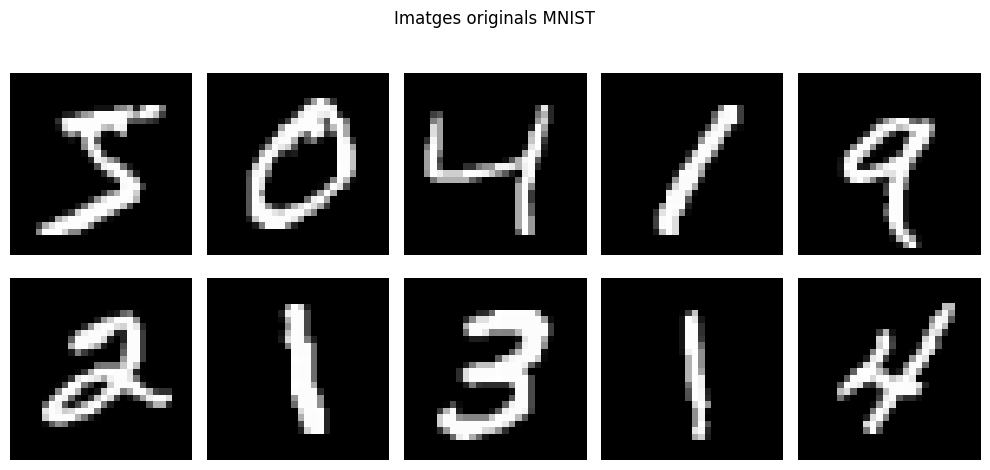

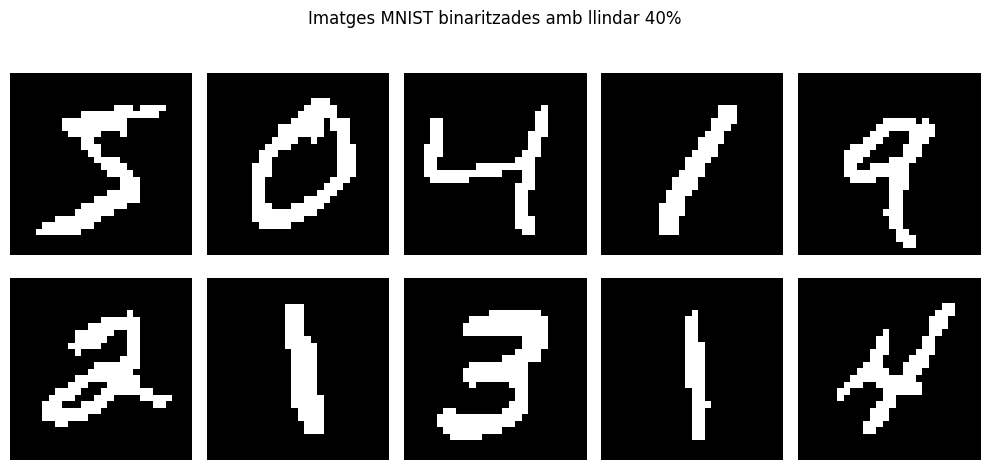

Forma de les dades: (70000, 28, 28, 1)


In [3]:
# Parametres del model i dades
num_classes = 10
input_shape = (28, 28, 1)

# millora 1: augmentem el nombre de blocs residuals de 5 a 8
n_residual_blocks = 8  # originalment era 5

# Carreguem les dades MNIST
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# Concatenem totes les imatges
data = np.concatenate((x_train, x_test), axis=0)

# Visualitzem algunes imatges originals
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i], cmap='gray')
    plt.axis('off')
plt.suptitle('Imatges originals MNIST')
plt.tight_layout()
plt.show()

# millora 2: canviem el llindar de binaritzacio del 33% al 40%
# aixo permet tenir mes detalls en les imatges generades
data = np.where(data < (0.40 * 256), 0, 1)  # originalment era 0.33
data = data.astype(np.float32)

# Visualitzem les mateixes imatges despres de la binaritzacio
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i], cmap='gray')
    plt.axis('off')
plt.suptitle('Imatges MNIST binaritzades amb llindar 40%')
plt.tight_layout()
plt.show()

# Afegim dimensio de canal per a Keras
data = data.reshape((-1, 28, 28, 1))
print(f"Forma de les dades: {data.shape}")

## Definicio de les capes personalitzades

Implementem les capes necessaries per a PixelCNN amb les millores incorporades.

In [4]:
# La primera capa es la PixelCNN, que implementa la convolucio amb mascara
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Construim la capa conv2d per inicialitzar les variables del kernel
        self.conv.build(input_shape)
        # Utilitzem el kernel inicialitzat per crear la mascara
        kernel_shape = ops.shape(self.conv.kernel)
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# millora 3: bloc residual modificat amb dropout per evitar sobreajustament
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        # afegim dropout per millorar la generalitzacio
        self.dropout = keras.layers.Dropout(dropout_rate)

    def call(self, inputs, training=None):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        # apliquem dropout nomes durant entrenament
        x = self.dropout(x, training=training)
        return keras.layers.add([inputs, x])

## Construccio del model millorat

Definim l'arquitectura del model amb totes les millores proposades.

In [16]:
inputs = keras.Input(shape=input_shape)

# millora 4: augmentem el nombre de filtres inicial de 128 a 256
x = PixelConvLayer(
    mask_type="A", filters=256, kernel_size=7, activation="relu", padding="same"
)(inputs)

# utilitzem els blocs residuals amb dropout
for i in range(n_residual_blocks):
    # millora 5: taxa de dropout progressiva (mes alta als primers blocs)
    dropout_rate = 0.2 - (i * 0.02)  # va de 0.2 a 0.06
    x = ResidualBlock(filters=256, dropout_rate=max(0.05, dropout_rate))(x)

# millora 6: afegim normalitzacio de capes per estabilitzar l'entrenament
x = layers.BatchNormalization()(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=256,  # doblat respecte l'original
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
)(x)

pixel_cnn = keras.Model(inputs, out)

# millora 7: utilitzem adam amb parametres optimitzats i programacio de taxa d'aprenentatge
inicial_lr = 0.001  # originalment era 0.0005
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    inicial_lr, decay_steps=1000, decay_rate=0.96, staircase=True
)

adam = keras.optimizers.Adam(learning_rate=inicial_lr)

# millora 8: utilitzem focal loss en lloc de binary_crossentropy per millorar
# la generacio de detalls fins
def focal_loss(gamma=2.0):
    def loss_function(y_true, y_pred):
        bce = keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
        # Canvi: Utilitzem tf.pow en lloc de ops.pow i mantenim la dimensio
        modulating_factor = tf.math.pow(1.0 - p_t, gamma)
        # Canvi: Assegurem que modulating_factor tingui la mateixa dimensio que bce
        # Eliminem la dimensio extra de modulating_factor usant squeeze:
        modulating_factor = tf.squeeze(modulating_factor, axis=-1)
        return tf.reduce_mean(modulating_factor * bce, axis=-1) #
    return loss_function # Return the inner function

pixel_cnn.compile(optimizer=adam, loss=focal_loss(gamma=2.0))

# mostrem el resum del model
pixel_cnn.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pixel_conv_layer_44 (PixelConvLayer) │ (None, 28, 28, 256)         │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_32 (ResidualBlock)    │ (None, 28, 28, 256)         │         393,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_33 (ResidualBlock)    │ (None, 28, 28, 256)         │         393,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_34 (ResidualBlock)    │ (None, 28, 28, 256)         │         393,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_35 (ResidualBlock)    │ (None, 28, 28, 256)         │         393,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_36 (ResidualBlock)    │ (None, 28, 28, 256)         │         393,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_37 (ResidualBlock)    │ (None, 28, 28, 256)         │         393,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_38 (ResidualBlock)    │ (None, 28, 28, 256)         │         393,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_39 (ResidualBlock)    │ (None, 28, 28, 256)         │         393,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pixel_conv_layer_53 (PixelConvLayer) │ (None, 28, 28, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pixel_conv_layer_54 (PixelConvLayer) │ (None, 28, 28, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_139 (Conv2D)                  │ (None, 28, 28, 1)           │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,296,513 (12.58 MB)

 Trainable params: 3,296,001 (12.57 MB)

 Non-trainable params: 512 (2.00 KB)

## Entrenament del model

Entrenarem el model amb callbacks addicionals per millorar el proces.

Iniciant entrenament del model...
Epoch 1/25


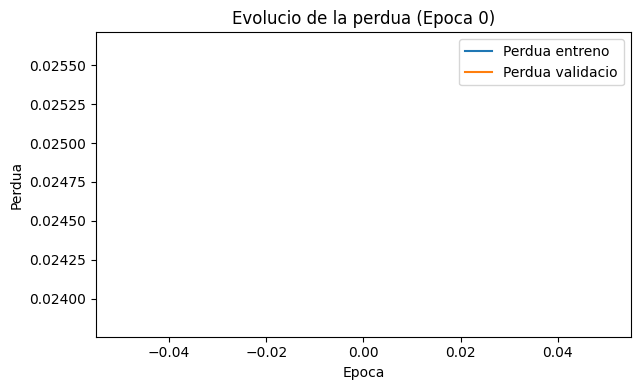

930/930 - 59s - 63ms/step - loss: 0.0256 - val_loss: 0.0238 - learning_rate: 1.0000e-03
Epoch 2/25
930/930 - 29s - 31ms/step - loss: 0.0230 - val_loss: 0.0224 - learning_rate: 1.0000e-03
Epoch 3/25
930/930 - 29s - 31ms/step - loss: 0.0225 - val_loss: 0.0223 - learning_rate: 1.0000e-03
Epoch 4/25
930/930 - 29s - 31ms/step - loss: 0.0222 - val_loss: 0.0221 - learning_rate: 1.0000e-03
Epoch 5/25
930/930 - 29s - 31ms/step - loss: 0.0220 - val_loss: 0.0218 - learning_rate: 1.0000e-03
Epoch 6/25


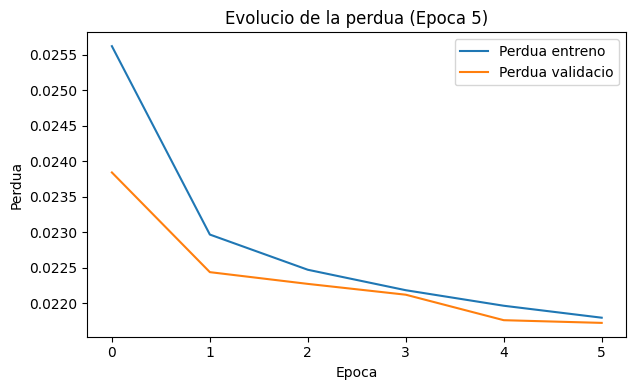

930/930 - 29s - 31ms/step - loss: 0.0218 - val_loss: 0.0217 - learning_rate: 1.0000e-03
Epoch 7/25
930/930 - 29s - 31ms/step - loss: 0.0217 - val_loss: 0.0217 - learning_rate: 1.0000e-03
Epoch 8/25
930/930 - 29s - 31ms/step - loss: 0.0216 - val_loss: 0.0215 - learning_rate: 1.0000e-03
Epoch 9/25
930/930 - 29s - 31ms/step - loss: 0.0215 - val_loss: 0.0215 - learning_rate: 1.0000e-03
Epoch 10/25
930/930 - 29s - 31ms/step - loss: 0.0214 - val_loss: 0.0215 - learning_rate: 1.0000e-03
Epoch 11/25


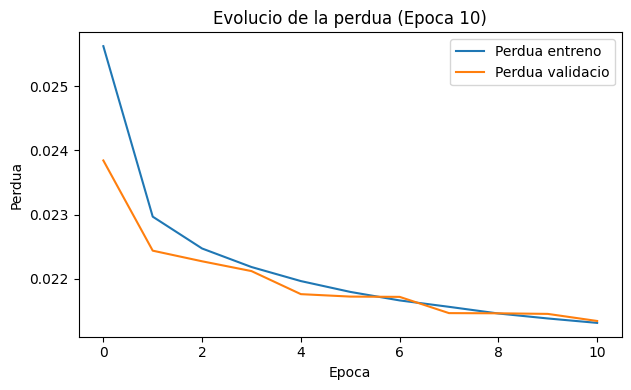

930/930 - 29s - 31ms/step - loss: 0.0213 - val_loss: 0.0213 - learning_rate: 1.0000e-03
Epoch 12/25
930/930 - 29s - 31ms/step - loss: 0.0213 - val_loss: 0.0213 - learning_rate: 1.0000e-03
Epoch 13/25
930/930 - 29s - 31ms/step - loss: 0.0212 - val_loss: 0.0213 - learning_rate: 1.0000e-03
Epoch 14/25
930/930 - 29s - 31ms/step - loss: 0.0211 - val_loss: 0.0212 - learning_rate: 1.0000e-03
Epoch 15/25
930/930 - 28s - 31ms/step - loss: 0.0211 - val_loss: 0.0212 - learning_rate: 1.0000e-03
Epoch 16/25


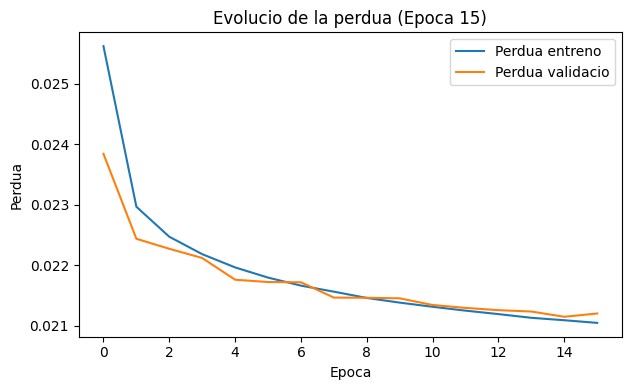

930/930 - 28s - 30ms/step - loss: 0.0210 - val_loss: 0.0212 - learning_rate: 1.0000e-03
Epoch 17/25
930/930 - 29s - 31ms/step - loss: 0.0210 - val_loss: 0.0212 - learning_rate: 1.0000e-03
Epoch 18/25
930/930 - 29s - 31ms/step - loss: 0.0208 - val_loss: 0.0211 - learning_rate: 5.0000e-04
Epoch 19/25
930/930 - 29s - 31ms/step - loss: 0.0207 - val_loss: 0.0211 - learning_rate: 5.0000e-04
Epoch 20/25
930/930 - 29s - 31ms/step - loss: 0.0207 - val_loss: 0.0211 - learning_rate: 5.0000e-04
Epoch 21/25


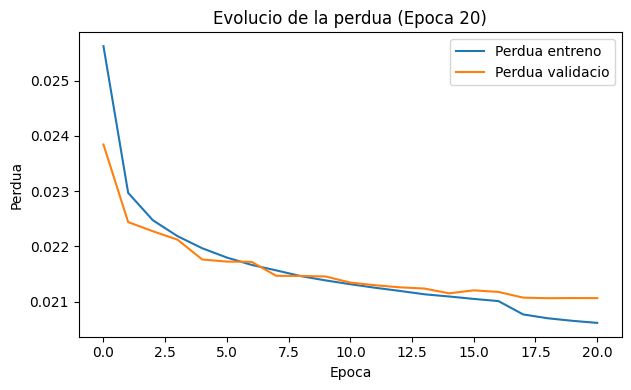

930/930 - 29s - 31ms/step - loss: 0.0206 - val_loss: 0.0211 - learning_rate: 5.0000e-04
Epoch 22/25
930/930 - 29s - 31ms/step - loss: 0.0205 - val_loss: 0.0210 - learning_rate: 2.5000e-04
Epoch 23/25
930/930 - 29s - 31ms/step - loss: 0.0204 - val_loss: 0.0210 - learning_rate: 2.5000e-04
Epoch 24/25
930/930 - 29s - 31ms/step - loss: 0.0204 - val_loss: 0.0210 - learning_rate: 2.5000e-04
Epoch 25/25
930/930 - 29s - 31ms/step - loss: 0.0203 - val_loss: 0.0211 - learning_rate: 1.2500e-04


In [17]:
# millora 9: afegim callbacks per monitoritzar l'entrenament
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=0.00001
)

# per visualitzar l'entrenament en temps real
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # guardem les metriques
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs[metric])
            else:
                self.metrics[metric] = [logs[metric]]

        # mostrem el grafic
        if epoch % 5 == 0 or epoch == 0:  # mostrem cada 5 epochs
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(self.metrics['loss'], label='Perdua entreno')
            if 'val_loss' in self.metrics:
                plt.plot(self.metrics['val_loss'], label='Perdua validacio')
            plt.title(f'Evolucio de la perdua (Epoch {epoch})')
            plt.xlabel('epoch')
            plt.ylabel('Perdua')
            plt.legend()
            plt.tight_layout()
            plt.show()

plot_learning = PlotLearning()

# millora 10: augmentem les epoques i afegim callbacks
print("Iniciant entrenament del model...")
history = pixel_cnn.fit(
    x=data,
    y=data,
    batch_size=64,
    epochs=25,
    validation_split=0.15,  # augmentem validacio del 10% al 15%
    callbacks=[early_stopping, reduce_lr, plot_learning],
    verbose=2
)

## Visualitzacio de l'evolucio de l'entrenament

Mostrem els grafics d'evolucio de la perdua durant l'entrenament.

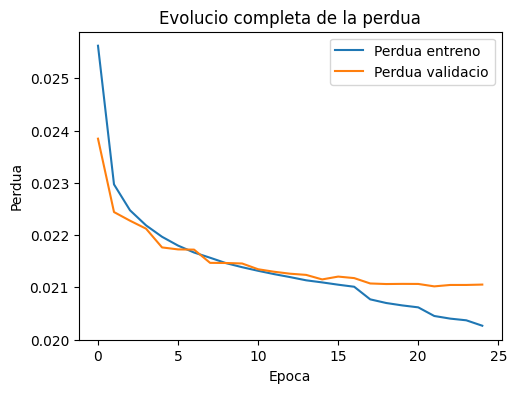

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perdua entreno')
plt.plot(history.history['val_loss'], label='Perdua validacio')
plt.title('Evolucio completa de la perdua')
plt.xlabel('Epoch')
plt.ylabel('Perdua')
plt.legend()

# guardem el grafic
plt.savefig("training_history.png")
plt.show()

## Generacio d'imatges

Utilitzem el model entrenat per generar noves imatges.

In [19]:
# millora 11: augmentem el nombre d'imatges generades i implementem temperature sampling
batch = 8  # augmentem el nombre d'imatges de 4 a 8
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

# millora 12: afegim temperature sampling per controlar la creativitat
temperature = 0.8  # < 1.0 fa prediccions mes conservadores, > 1.0 mes creatives

print("Generant imatges pixel a pixel...")
# iterem pels pixels ja que la generacio s'ha de fer sequencialment
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            # obtenim les probabilitats pel seguent pixel
            probs = pixel_cnn.predict(pixels, verbose=0)[:, row, col, channel]

            # apliquem temperature sampling
            if temperature != 1.0:
                probs = np.log(probs + 1e-8) / temperature
                probs = np.exp(probs) / np.sum(np.exp(probs), axis=-1, keepdims=True)

            # utilitzem les probabilitats per escollir els valors dels pixels
            pixels[:, row, col, channel] = ops.ceil(
                probs - tf.random.uniform(probs.shape)
            )

Generant imatges pixel a pixel...


100%|██████████| 28/28 [01:03<00:00,  2.27s/it]


## Visualitzacio de les imatges generades

Mostrem les imatges creades pel model.

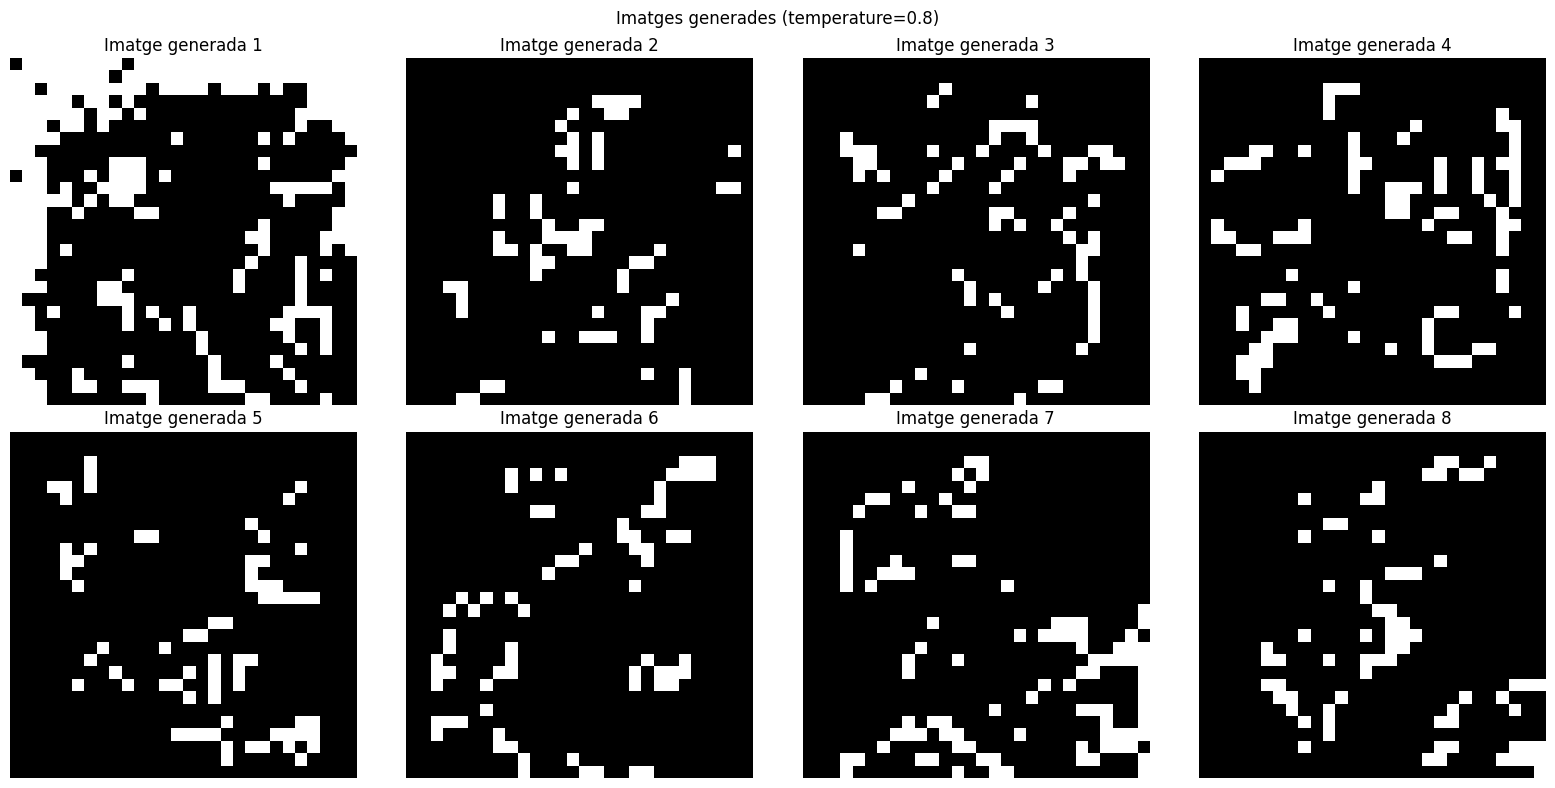

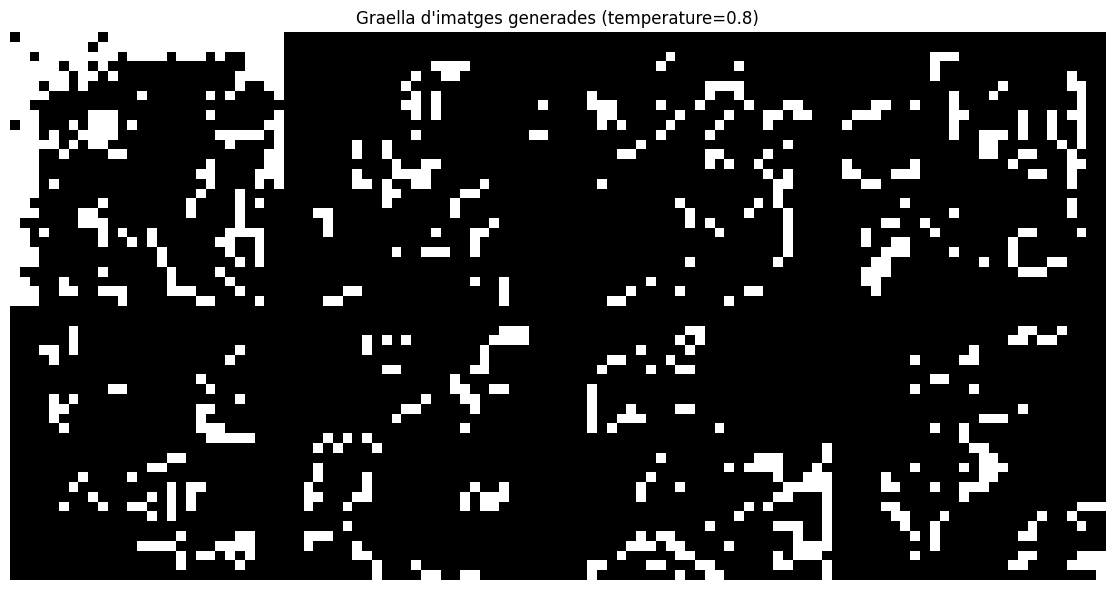

In [20]:
def deprocess_image(x):
    # apilem el canal blanc i negre a valors rgb
    x = np.stack((x, x, x), 2)
    # desfem el preprocessament
    x *= 255.0
    # convertim a uint8 i limitem al rang valid [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# millora 13: visualitzem les imatges generades individualment
plt.figure(figsize=(16, 8))
for i in range(batch):
    plt.subplot(2, 4, i+1)
    img = deprocess_image(np.squeeze(pixels[i], -1))
    plt.imshow(img)
    plt.title(f"Imatge generada {i+1}")
    plt.axis("off")
    # guardem cada imatge
    tf.keras.utils.save_img(f"generated_image_{i}.png", img)

plt.suptitle(f"Imatges generades (temperature={temperature})")
plt.tight_layout()
plt.savefig("generated_images.png")
plt.show()

# millora 14: creem una graella d'imatges
def create_image_grid(images, grid_size=(2, 4)):
    h, w = grid_size
    assert len(images) == h * w, f"Nombre d'imatges ({len(images)}) no coincideix amb la graella {grid_size}"

    # obtenim mides d'imatge
    img_h, img_w = images[0].shape[0], images[0].shape[1]

    # creem una graella buida
    grid = np.zeros((h * img_h, w * img_w, 3), dtype=np.uint8)

    # omplim la graella
    for idx, image in enumerate(images):
        i = idx // w
        j = idx % w
        grid[i * img_h:(i + 1) * img_h, j * img_w:(j + 1) * img_w, :] = deprocess_image(np.squeeze(image, -1))

    return grid

# creem i guardem la graella d'imatges
grid = create_image_grid(pixels, grid_size=(2, 4))
plt.figure(figsize=(12, 6))
plt.imshow(grid)
plt.title(f"Graella d'imatges generades (temperature={temperature})")
plt.axis("off")
plt.tight_layout()
plt.savefig("generated_grid.png")
plt.show()

## Experiments addicionals amb diferents temperatures

Provem diferents configuracions de temperature sampling per veure com afecta la creativitat del model.


Generant imatges amb temperature=0.5...


100%|██████████| 28/28 [01:04<00:00,  2.31s/it]


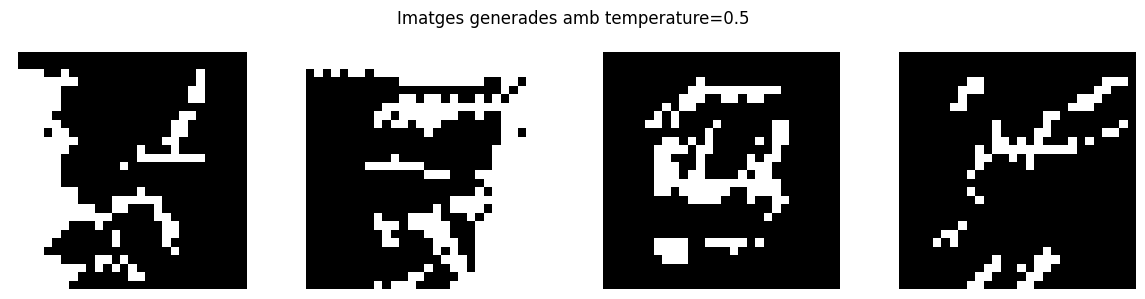


Generant imatges amb temperature=1.0...


100%|██████████| 28/28 [01:03<00:00,  2.25s/it]


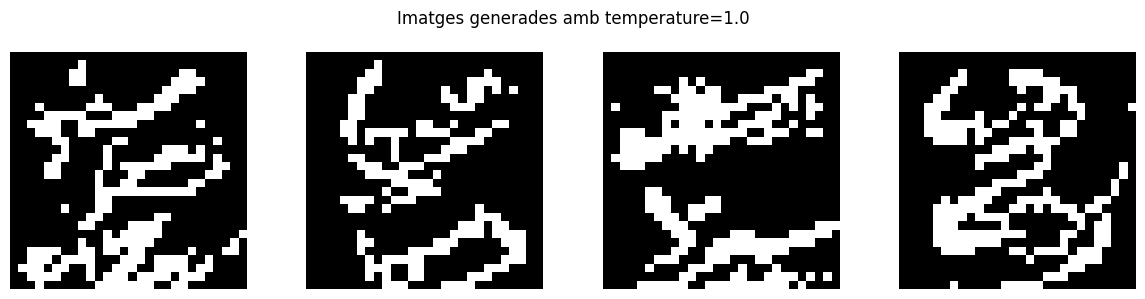


Generant imatges amb temperature=1.5...


100%|██████████| 28/28 [01:02<00:00,  2.25s/it]


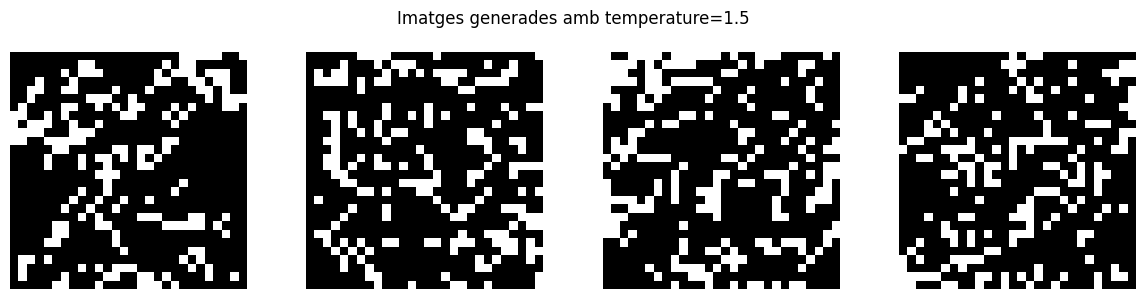

In [21]:
# millora 15: experimentem amb diferents temperatures
temperatures = [0.5, 1.0, 1.5]
results = []

for temp in temperatures:
    print(f"\nGenerant imatges amb temperature={temp}...")
    # inicialitzem una nova imatge buida
    pixels = np.zeros(shape=(4,) + (pixel_cnn.input_shape)[1:])  # 4 imatges per cada temperatura
    batch, rows, cols, channels = pixels.shape

    # iterem pels pixels
    for row in tqdm(range(rows)):
        for col in range(cols):
            for channel in range(channels):
                # obtenim les probabilitats
                probs = pixel_cnn.predict(pixels, verbose=0)[:, row, col, channel]

                # apliquem temperature sampling
                if temp != 1.0:
                    probs = np.log(probs + 1e-8) / temp
                    probs = np.exp(probs) / np.sum(np.exp(probs), axis=-1, keepdims=True)

                # utilitzem les probabilitats per escollir els valors
                pixels[:, row, col, channel] = ops.ceil(
                    probs - tf.random.uniform(probs.shape)
                )

    # guardem els resultats
    results.append((temp, pixels))

    # mostrem i guardem les imatges
    plt.figure(figsize=(12, 3))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        img = deprocess_image(np.squeeze(pixels[i], -1))
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Imatges generades amb temperature={temp}")
    plt.tight_layout()
    plt.savefig(f"generated_temp_{temp}.png")
    plt.show()

## Guardar el model per a futurs usos

Model guardat a pixelcnn_millora_model.keras
Pesos del model guardats correctament
	zip warning: name not matched: path_model
updating: generated_grid.png (deflated 31%)
updating: generated_image_0.png (stored 0%)
updating: generated_image_1.png (stored 0%)
updating: generated_image_2.png (stored 0%)
updating: generated_image_3.png (stored 0%)
updating: generated_image_4.png (stored 0%)
updating: generated_image_5.png (stored 0%)
updating: generated_image_6.png (stored 0%)
updating: generated_image_7.png (stored 0%)
updating: generated_images.png (deflated 33%)
updating: generated_temp_0.5.png (deflated 22%)
updating: generated_temp_1.0.png (deflated 21%)
updating: generated_temp_1.5.png (deflated 21%)
updating: training_history.png (deflated 13%)
updating: pixelcnn_millora_pesos.weights.h5 (deflated 19%)

Tots els resultats han estat comprimits en pixelcnn_results.zip per facilitar la descarrega

Exemple de com carregar el model i generar noves imatges:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'residual_block_32', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'residual_block_33', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'residual_block_34', however t

Model carregat de pixelcnn_millora_model.keras
Generant 4 imatges amb temperatura 0.8...


100%|██████████| 28/28 [01:05<00:00,  2.35s/it]


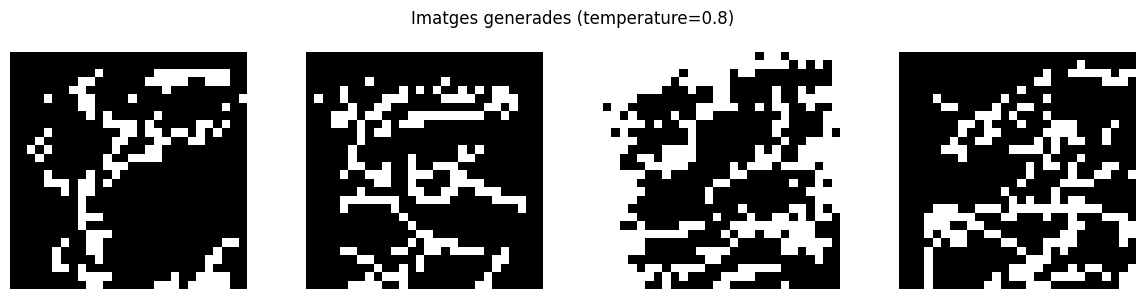

Model guardat a pixelcnn_millora_model.keras


In [28]:
# guardem el model entrenat per poder utilitzar-lo mes endavant
path_model = "pixelcnn_millora_model.keras"
pixel_cnn.save(path_model)
print(f"Model guardat a {path_model}")

# tambe podem guardar nomes els pesos si volem
pixel_cnn.save_weights("pixelcnn_millora_pesos.weights.h5")
print("Pesos del model guardats correctament")

# comprimir els resultats per descarregar-los facilment de Colab
!zip -r pixelcnn_results.zip *.png path_model *.h5
print("\nTots els resultats han estat comprimits en pixelcnn_results.zip per facilitar la descarrega")

# millora 16: afegim funcio de carrega del model per facilitar el seu us posterior
def carregar_model(path_model="pixelcnn_millora_model.keras", path_pesos=None):
    """
    funcio que permet carregar el model guardat o nomes els pesos

    parametres:
    - path_model: ruta al model complet (si es vol carregar el model sencer)
    - path_pesos: ruta als pesos (si nomes es volen carregar els pesos)

    retorna:
    - model carregat
    """
    if path_pesos is not None:
        # si volem carregar nomes els pesos, primer cal recrear l'arquitectura
        inputs = keras.Input(shape=input_shape)
        x = PixelConvLayer(mask_type="A", filters=256, kernel_size=7, activation="relu", padding="same")(inputs)

        for i in range(n_residual_blocks):
            dropout_rate = 0.2 - (i * 0.02)
            x = ResidualBlock(filters=256, dropout_rate=max(0.05, dropout_rate))(x)

        x = layers.BatchNormalization()(x)

        for _ in range(2):
            x = PixelConvLayer(
                mask_type="B",
                filters=256,
                kernel_size=1,
                strides=1,
                activation="relu",
                padding="valid",
            )(x)

        out = keras.layers.Conv2D(
            filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
        )(x)

        model = keras.Model(inputs, out)
        model.load_weights(path_pesos)
        print(f"Pesos carregats de {path_pesos}")
        return model
    else:
        # carreguem el model complet
        model = keras.models.load_model(
            path_model,
            custom_objects={
                "PixelConvLayer": PixelConvLayer,
                "ResidualBlock": ResidualBlock,
                "loss_function": focal_loss(gamma=2.0)
            }
        )
        print(f"Model carregat de {path_model}")
        return model

# millora 17: funcio per generar noves imatges amb el model carregat
def generar_imatges(model, num_imatges=4, temperatura=0.8):
    """
    funcio per generar noves imatges amb el model

    parametres:
    - model: model pixelcnn carregat
    - num_imatges: nombre d'imatges a generar
    - temperatura: control de creativitat (< 1.0 mes conservador, > 1.0 mes creatiu)

    retorna:
    - pixels: array amb les imatges generades
    """
    # inicialitzem els pixels a zeros
    pixels = np.zeros(shape=(num_imatges,) + (model.input_shape)[1:])
    batch, rows, cols, channels = pixels.shape

    print(f"Generant {num_imatges} imatges amb temperatura {temperatura}...")

    # generem pixel a pixel
    for row in tqdm(range(rows)):
        for col in range(cols):
            for channel in range(channels):
                # obtenim les probabilitats
                probs = model.predict(pixels, verbose=0)[:, row, col, channel]

                # apliquem temperature sampling
                if temperatura != 1.0:
                    probs = np.log(probs + 1e-8) / temperatura
                    probs = np.exp(probs) / np.sum(np.exp(probs), axis=-1, keepdims=True)

                # seleccionem els valors
                pixels[:, row, col, channel] = ops.ceil(
                    probs - tf.random.uniform(probs.shape)
                )

    return pixels

# Exemple d'us de les funcions afegides
print("\nExemple de com carregar el model i generar noves imatges:")
model = carregar_model(path_model)
pixels = generar_imatges(model, num_imatges=4, temperatura=0.8)
plt.figure(figsize=(12, 3))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = deprocess_image(np.squeeze(pixels[i], -1))
    plt.imshow(img)
    plt.axis("off")
plt.suptitle(f"Imatges generades (temperature=0.8)")
plt.tight_layout()
plt.show()

# guardem el model entrenat per poder utilitzar-lo mes endavant
model_path = "pixelcnn_millora_model.keras"  # afegim l'extensio .keras
pixel_cnn.save(model_path)
print(f"Model guardat a {model_path}")